(onboardone)=
# Import a World Bank Eviews model from its solution file (.wf1)
This notebook takes a .wf1 workfile and transforms it into a modelflow model.

Most standard World Bank models should work with limited intervention.  Some using unusual techniques or variable definitions may require intervention by the user.

## Overview of the import process

The overall import process is performed by a special a ModelFlow class named:**GrabWfModel**. Certain steps require the use of EViews itself.  This howoto was designed usinng EViews version 12, but and has been tested with versions 13 and 14.

Steps to follow:
 1. Start EViews and open the solution file 
    -    If returning to this step after an initial error perform transformations on the data (needed in some cases where special EViews functions are used in the model).
    -    The UNlink the model. This transforms linked equations into explicit equations in the EViews model object. 
    -    Save the revised model and data as a .wf2 file. (the .wf2 is a JSON format that can be easily read into python).
    **QCVD?  Same name with ```_modelflow appended```**
 5. Close Eviews.
 6. The wf2 file is read as a json file. 
 7. Relevant objects are extracted. 
 7. The MFMSA variable is  extracted, to be saved in the dumpfile. 
 8. The equations are transformed and normalized to modelflow format and classified into identities and stochastic
 9. Stochastic equations are enriched by add_factor and fixing terms (dummy + fixing value)  
 9. For Stochastic equations new fitted variables are generated - without add add_factors and dummies.  
 9. A model to generate fitted variables is created  
 9. A model to generate add_factors is created. 
 9. A model encompassing the original equations, the model for fitted variables and for add_factors is created. 
 9. The data series and scalars are shoveled into a Pandas dataframe 
     - Some special series are generated as the expression can not be incorporated into modelflow model specifications
     - The model for fitted values is simulated in the specified timespan
     - The model for add_factors is simulated in the timespan set in MFMSA
 10. The data descriptions are extracted into a dictionary. 
    - Data descriptions for dummies, fixed values, fitted values and add_factors are derived. 
 11. Now we have a model and a dataframe with all variables which are needed.
 
The GrapWfModel instance in general keeps most of the steps so the developer can inspect the the different steps.  


## Prerequisites  

The import process requires EViews and tehrefore cannot be run on a non-windows computerthat does not have EViews 12 or later installed.  It also assumes that the python library `pyeviews` has been installed (`conda install pyeviews`).  `pyeviews` uses the EViews com interface to control eviews, allowing a python script to directly manipulate parts of the eviews model using eviews itself.  This is required only for the import process.


In [4]:
from pathlib import Path

from modelclass import model 
from modelgrabwf2 import GrabWfModel  #this is the class (part of the Modelflow Library) that will translate
                                      # the ewbvis model and equations into modelflow business logic and
                                      # import the data into pandas
model.widescreen() # Makes modelflow aware we may be running under a wider than normal screem
model.scroll_off() # tells modelflow not to scroll outputs

<IPython.core.display.Javascript object>

In [5]:

all_about_mda = GrabWfModel(r'wfs\bolsoln.wf1', 
                  #eviews_run_lines= mda_eviews_run_lines,
                  #country_trans    =  mda_trans,
                    make_fitted = True,        # make equatios for fitted values of stocastic equations 
                    do_add_factor_calc=True,   # Calculate the add factors which makes the stocastic equations match    
                    fit_start = 2000,          # Start of calculation of fittet model in baseline (to have some historic values) 
                    fit_end   = None,           # end of calc for fittted model, if None taken from mdmfsa options  
                    disable_progress =True     # Better for jupyter book 
                           ) 


Reading c:\modelflow manual\papers\mfbook\content\archived\howto\onboard\eviews\wfs\bolsoln.wf1
Assummed model name: BOL
The model: BOL is unlinked 
Writing C:\modelflow manual\papers\mfbook\content\archived\howto\onboard\eviews\wfs\bolsoln_modelflow.wf2
Model name: BOL

Processing the model:BOL
Check for Eviews @ which are not caught in the translation
Probably errors as @ in lines:

Eviews line      :@IDENTITY BOLBFCAF2BOP_  = (1  - @DURING("1980 2021"))  * @between(reserveRatio3  , 1  / 2  , 100000)  * reserveRatio3
Original line     :@IDENTITY BOLBFCAF2BOP_  = (1  - DURING_1980_2021)  * @BETWEEN(RESERVERATIO3  , 1  / 2  , 100000)  * RESERVERATIO3
New modelflow line:BOLBFCAF2BOP_=(1-DURING_1980_2021)*@BETWEEN(RESERVERATIO3,1/2,100000)*RESERVERATIO3


Exception: @ in lines 

## Debugging the error


GrabWfModel knows some Eviews @<functions> but not all. As we can see from the line: 

 >New modelflow line:BOLBFCAF2BOP_=(1-DURING_1980_2021)*@BETWEEN(RESERVERATIO3,1/2,100000)*RESERVERATIO3

 GrabWfModel can not make @Between go away. That is causing trouble.

The EViews help tells us:

```
@between(series, val1, val2)  Creates a dummy variable equal to 1 for observations where series is greater than or equal to val1 and less than or equal to val2.
```

In python @between(series, val1, val2) is equivalent to: 
    
 >  (1. * float(val1 <= series <= val2)))  
    
We can reproduce the logic by adding a python commmand to perform the substitution of @between in the equation with a equivalent 
python expression 


```BOL_trans = lambda text: re.sub(
    r"@BETWEEN\(\s*(\w+)\s*,\s*([^,]+)\s*,\s*([^)]+)\s*\)",
    r"(1.0*float(\1 <= \2 <= \3))",
    text
)```


In [7]:
import re
BOL_trans = lambda text: re.sub(
    r"@BETWEEN\(\s*(\w+)\s*,\s*([^,]+)\s*,\s*([^)]+)\s*\)",
    r"(1.0*float(\1 <= \2 <= \3))",
    text
)


# Usage example
text = '@BETWEEN(3  , 1  / 2  , 100000)'
result = BOL_trans(text)

print(result)


(1.0*float(3 <= 1  / 2   <= 100000))


In [8]:
# some results 
print(f'{1.0*((1  / 2)   <= 30 <= 100000)=}')
print(f'{1.0*((1  / 2)   <= 30000 <= 100000)=}')
print(f'{1.0*((1  / 2)   <= 0 <= 100000)=}')

1.0*((1  / 2)   <= 30 <= 100000)=1.0
1.0*((1  / 2)   <= 30000 <= 100000)=1.0
1.0*((1  / 2)   <= 0 <= 100000)=0.0


In [10]:

BOL_trans=lambda text: re.sub(
    r"@between\(\s*(\w+)\s*,\s*([^,]+)\s*,\s*([^)]+)\s*\)",
    r"(1.0*float(\1 <= \2 <= \3))",
    text
)
all_about_mda = GrabWfModel(r'wfs\bolsoln.wf1', 
                  country_trans    =  BOL_trans,
                    make_fitted = True,        # make equatios for fitted values of stocastic equations 
                    do_add_factor_calc=True,   # Calculate the add factors which makes the stocastic equations match    
                    fit_start = 2000,          # Start of calculation of fittet model in baseline (to have some historic values) 
                    fit_end   = None,           # end of calc for fittted model, if None taken from mdmfsa options  
                    disable_progress =True     # Better for jupyter book 
                           ) 


Reading c:\modelflow manual\papers\mfbook\content\archived\howto\onboard\eviews\wfs\bolsoln.wf1
Assummed model name: BOL
The model: BOL is unlinked 
Writing C:\modelflow manual\papers\mfbook\content\archived\howto\onboard\eviews\wfs\bolsoln_modelflow.wf2
Model name: BOL

Processing the model:BOL
Check for Eviews @ which are not caught in the translation
Default WB var_group loaded
Variable description in wf1 file read
Default WB var_description loaded self.cty='' len(var_description)=16
var_description loaded from WF len(this)=301
testmodel calculated  
Calculation of add factors for BOL calculated  


C:\modelflow2\modelflow\modelgrabwf2.py:579: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_out = self.mmodel.insertModelVar(df).pipe(self.country_df_trans).fillna(0.0)


## Check if each equation on its own result in the values provided. 
aka: residual check <br> 
If they are not pretty close, something is very wrong. 

In [11]:
all_about_mda.test_model(all_about_mda.start,all_about_mda.end,maxerr=100,tol=1,showall=0)   # tol determins the max acceptable absolute difference 

BOL calculated  

Chekking residuals for BOL 2015 to 2030

Variable with residuals above threshold
BOLNYGDPPOTLKN              , Max difference:   121.79006866 Max Pct    0.2060497541% It is number    49 in the solveorder and error number 1
BOLBFCAFRACGCD              , Max difference:   153.81440796 Max Pct    8.9638164261% It is number   142 in the solveorder and error number 2
BOLNEGDIKSTKKN              , Max difference:   790.08766813 Max Pct    0.5305890811% It is number   212 in the solveorder and error number 3
BOLBFCAF2BOP_               , Max difference:     1.49093138 Max Pct  100.0000000000% It is number   221 in the solveorder and error number 4


## Extract the model and the baseline
**all_about_mda** has a lot of content including. 
- .mmodel is the model instance
- .base_input is the baseline where the add factors and the fitted values are calculated 

In [12]:
mmda    = all_about_mda.mmodel       # the model instance  
baseline = all_about_mda.base_input

## Run the model 
In order to achieve numerical stability Gauss-Seidle has to be dampened: alfa=0.7 makes sure that the solution does not explode. 
The convergence criteria is tightend a lot. 

In [22]:
res = mmda(all_about_mda.base_input,2016,2040,silent=0,alfa=0.3,ldumpvar=0,)
mmda.basedf = all_about_mda.base_input

Will start solving: BOL
Reusing the solver as no new data 
2016 Solved in 6 iterations
2017 Solved in 6 iterations
2018 Solved in 6 iterations
2019 Solved in 6 iterations
2020 Solved in 6 iterations
2021 Solved in 6 iterations
2022 Solved in 6 iterations
2023 Solved in 6 iterations
2024 Solved in 6 iterations
2025 Solved in 65 iterations
>> Error in     : BOL
>> In           : 2025
>> varposition   : 197
>> Equation     : FRML <FIT> BOLFISCASHCN_FITTED = BOLFISCASHCN(-1)*EXP( (((LOG(BOLBCBEMISCN))-(LOG(BOLBCBEMISCN(-1))))-0.00236125559643038*DUMH) ) $
A snapshot of the data at the error point is at .errdump 
Also the .lastdf contains .errdump,  for inspecting 

Calculations of BOLFISCASHCN_FITTED 
FRML <FIT> BOLFISCASHCN_FITTED = BOLFISCASHCN(-1)*EXP( (((LOG(BOLBCBEMISCN))-(LOG(BOLBCBEMISCN(-1))))-0.00236125559643038*DUMH) ) $

Looking at period:2025
BOLFISCASHCN_FITTED =    114600.4986732296
BOLBCBEMISCN        =  -371514.50199609896
BOLBCBEMISCN(-1)    =   59178.511079121796
BOLFISCA

ValueError: math domain error

## And the simulation result is also fine. 
Here the percent difference is displayed

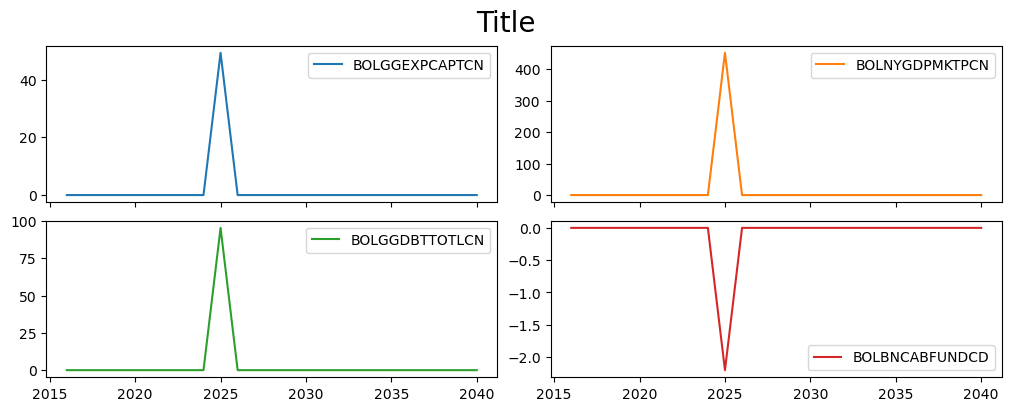

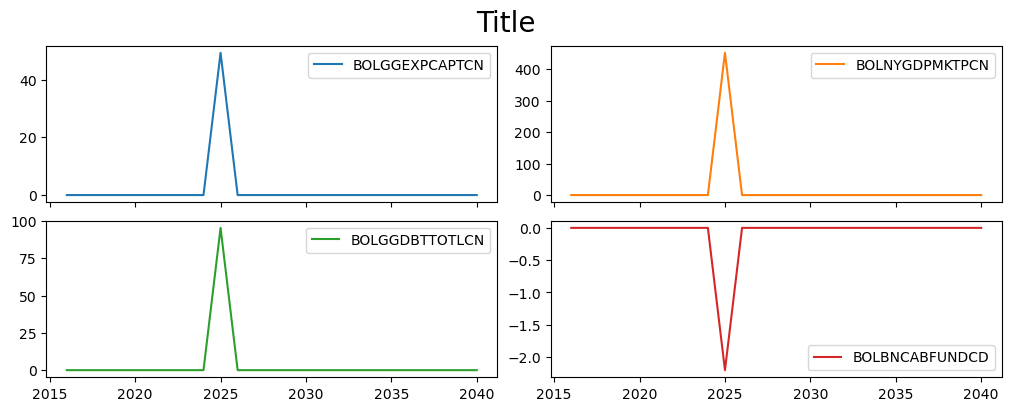

In [17]:
mmda['{cty}GGEXPCAPTCN {cty}NYGDPMKTPCN {cty}GGDBTTOTLCN {cty}BNCABFUNDCD'].dif.plot() 

## Look at a stochastic variable 
Here the equations undergo more phases 

In [ ]:
all_about_mda.all_frml_dict['MDABFCAFCAPTCD'].fprint

## Look a all the modelflow frmls
Notice after the "original" model the equations for the "fitted" values have been added. <br>
Also in the end of the listing the specification of the model which calculates the add factors if a variable is fixed. When processing the equations the ```model``` class will process this this model separately and create a model instance 
which is used to calculate add factors in case 

In [18]:
print(mmda.equations)

FRML <IDENT> BOLNYGDPPOTLKN = BOLNYGDPTFP*(BOLLMEMPSTRL**BOLNYYWBTOTLCN_)*(BOLNEGDIKSTKKN(-1)**(1-BOLNYYWBTOTLCN_)) $
FRML <IDENT> BOLNYGDPPOTLKD = (BOLNYGDPPOTLKN*((BOLNYGDPMKTPCN_VALUE_2015)/((BOLNYGDPMKTPKN_VALUE_2015))))/(BOLPANUSATLS_VALUE_2015) $
FRML <IDENT> BOLNYGDPGAP_ = ((BOLNYGDPMKTPKN/BOLNYGDPPOTLKN-1)*100) $
FRML <IDENT> BOLNEGDIKSTKKN = BOLNEGDIKSTKKN(-1)*(1-BOLDEPR/100)+BOLNEGDIFTOTKN $
FRML <IDENT> BOLNYKRTTOTLXN = BOLNEGDIFPRVXN*(BOLFMLBLLRLCFR/100+BOLNEKRTPREMFR/100+BOLDEPR/100-BOLINFLEXPT/100) $
FRML <IDENT> BOLGDPPCKN = (BOLNYGDPMKTPKN/BOLSPPOPTOTL) $
FRML <IDENT> BOLGDPPCKD = (BOLNYGDPMKTPKD/BOLSPPOPTOTL) $
FRML <IDENT> BOLLMLBFTOTL = BOLLMPRTTOTL_/100*BOLSPPOPWORK $
FRML <IDENT> BOLNYYWBTOTLCN = BOLNEWRTTOTLXN*BOLLMEMPTOTL $
FRML <IDENT> BOLLMEMPSTRL = (1-BOLLMUNRSTRL_/100)*BOLLMPRTSTRL_/100*BOLSPPOPWORK $
FRML <IDENT> BOLLMUNRTOTL_ = (1-BOLLMEMPTOTL/BOLLMLBFTOTL)*100 $
FRML <IDENT> BOLNYGDPMKTPKN = BOLNECONPRVTKN+BOLNECONGOVTKN+BOLNEGDIFTOTKN+BOLNEGDISTKBKN+BOLNE

In [ ]:
mmda.modeldump('test.pcim')

In [ ]:
!dir *.pcim